## Building Time Series Models to predict the price of gold
---
Project notebook organisation:<br>
**1_ARIMA_Models** (current notebook)<br>
<a href='./2_EDA_and_Preprocessing.ipynb'>2_FaceBook_Prophet</a><br>
<a href='./3_Models.ipynb'>3_VAR</a><br>

---
### This notebook's layout
<a href='#dict'>Data dictionary</a><br>
<a href='#import'>Data Import and Cleaning</a><br>
<a href='#gct'>Granger Causality Test</a><br>
<a href='#adf'>Augmented Dickey–Fuller test</a><br>
<a href='#base'>Baseline prediction with SARIMA (no exogenous variables)</a><br>
<a href='#sx1'>SARIMAX models (with single exogenous variable)</a><br>
<a href='#sx2'>SARIMAX (with 2 exogenous variables)</a><br>
<a href='#full_sx'>Full model SARIMAX</a><br>
<a href='#export'>Export data</a><br>

### Problem statement

I am a financial quantitative analyst with a Hedge fund company. 

Time Series forecasting & modeling plays an important role in data analysis. <br> 
Time series analysis is a specialized branch of statistics used extensively <br> 
in fields such as Econometrics & Operation Research.<br> 

In [222]:
import pandas as pd
from pandas.plotting import lag_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [164]:
%%html
<style>
table {float:left}
</style>

<a id='dict'></a>
### Data dictionary

| Feature           | Description                          | Duration | From | To   | Counts | Source                                        |
| :----------------- | :------------------------------------ | :-------- | :---- | :---- | :------ | :-------------------------------------------- |
| gold_price        | gold  spot price                     | Month    | 1970 | 2020 | 606    | https://www.gold.org/goldhub/data/gold-prices |
| gld               | gold  ETF                            | Day      | 2005 | 2020 | 3880   | yahoo                                         |
| gold_cfd          | gold  cfd                            | Hour     | 2006 | 2020 | 85k    | https://www.quantconnect.com/data/tree        |
| usd_index         | usd relative to basket of currencies | Day      | 2010 | 2020 | 600    | ticker:DX-Y.NYB.  Download from yahoo         |
| fed_interest_rate | interest  rate                       | Month    | 1954 | 2020 | 798    | https://fred.stlouisfed.org/series/FEDFUNDS   |
| us_cpi_inflation  | US  inflation rate                   | Month    | 1947 | 2020 | 888    | https://fred.stlouisfed.org/series/CPIAUCSL   |

<a id='import'></a>
### Data Import and Cleaning

In [165]:
gold = pd.read_csv('../data/gold_price.csv',parse_dates=['Name'])
cpi = pd.read_csv('../data/cpiaucsl_with_8mths_fcast.csv',parse_dates=['DATE'])
rates = pd.read_csv('../data/fedfunds_with_8mths_fcast.csv',parse_dates=['DATE'])
usd = pd.read_csv('../data/dxy_with_8mths_fcast.csv',parse_dates=['Date'])

<style>
    
    | Feature           | Description                          | Duration | From | To   | Counts | Link                                          |
| ----------------- | ------------------------------------ | -------- | ---- | ---- | ------ | :-------------------------------------------- |
| gold_price        | gold  spot price                     | Month    | 1970 | 2020 | 606    | https://www.gold.org/goldhub/data/gold-prices |
| gld               | gold  ETF                            | Day      | 2005 | 2020 | 3880   | yahoo                                         |
| gold_cfd          | gold  cfd                            | Hour     | 2006 | 2020 | 85k    | https://www.quantconnect.com/data/tree        |
| usd_index         | usd relative to basket of currencies | Day      | 2010 | 2020 | 600    | ticker:DX-Y.NYB.  Download from yahoo         |
| fed_interest_rate | interest  rate                       | Month    | 1954 | 2020 | 798    | https://fred.stlouisfed.org/series/FEDFUNDS   |
| us_cpi_inflation  | US  inflation rate                   | Month    | 1947 | 2020 | 888    | https://fred.stlouisfed.org/series/CPIAUCSL   |
</style>

In [166]:
gold.rename(columns={'Name':'Date'}, inplace=True)
gold.rename(columns={'US dollar':'spot_gold'}, inplace=True)
cpi.rename(columns={'DATE':'Date'}, inplace=True)
rates.rename(columns={'DATE':'Date'}, inplace=True)

In [167]:
# The days in the dates are randomn. Need to replace and standarised all days to '01'
gold['Date'] = gold['Date'].apply(lambda dt: dt.replace(day=1))

In [168]:
# Sets all Date as index
gold.set_index('Date', inplace=True)
cpi.set_index('Date', inplace=True)
rates.set_index('Date', inplace=True)
usd.set_index('Date', inplace=True)

In [169]:
# Specifying index freq enables better working with statsmodel
gold.index.freq='MS'
cpi.index.freq='MS'
rates.index.freq='MS'
usd.index.freq='MS'

In [170]:
gold = gold.loc['1971-01-01':]
cpi = cpi.loc['1971-01-01':]
rates = rates.loc['1971-01-01':]

In [171]:
print(rates.shape)
print(cpi.shape)
print(usd.shape)

(600, 1)
(600, 1)
(600, 1)


In [172]:
gold.shape

(592, 1)

In [173]:
combined = pd.concat([gold, cpi, rates,usd ], axis=1)

In [174]:
combined.shape

(600, 4)

In [175]:
combined.rename(columns={'CPIAUCSL':'us_cpi_inflation'}, inplace=True)
combined.rename(columns={'FEDFUNDS':'fed_interest_rate'}, inplace=True)
combined.rename(columns={'Price':'usd_index'}, inplace=True)

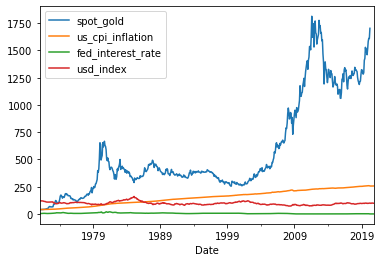

In [176]:
combined.plot()

In [177]:
combined.isna().sum()

spot_gold            8
us_cpi_inflation     0
fed_interest_rate    0
usd_index            0
dtype: int64

In [178]:
# The 3 exogenous variables(cpi,usd, rates) have future/forecasted values(may-dec2020)
# Gold price is not known (may-dec2020), so lets just get from 1970 to Apr_2020
# Essentially, creating 2 combined datasets
# combined(and gold price at nan) dataset has future values; combined_to_Apr20 has no future values (uniform data)
combined_to_Apr20 = combined.loc[:'2020-04-01']

In [179]:
# evidence of a very strong autocorrelation; 
# as 𝑦𝑡  values increase, nearby (lagged) values also increase
#lag_plot(combined_to_Apr20['spot_gold']);

<a id='gct'></a>
### Granger Causality Test

Granger causality investigates causality between two variables in a time series<br>
p values lower than 0.05, indicates that the mentioned x(t) variable `granger causes` the target y(t), which is gold price

In [180]:
def get_best_gct(gct_output_var, exog_var_name):
    """Returns no. of lags where the p value is lowest"""
    list1=[]
    for nlag in range(1,4,1): # maxlag=3 is standard
        temp_p_value = gct_output_var[nlag][0]['ssr_ftest'][1]
        list1.append(temp_p_value)
    min1 = min(list1) # gets the min value inside list
    min_posn = list1.index(min(list1)) + 1 # Need to plus 1 due to list item length
    print(F'{exog_var_name} minimum P value is {min1} with no.of lag at {min_posn}')

In [181]:
# Running granger causality tests on the 3 potential exogenous variables
gct_result_cpi = grangercausalitytests(combined_to_Apr20[['spot_gold','us_cpi_inflation']],maxlag=3,verbose=False);
gct_result_rate = grangercausalitytests(combined_to_Apr20[['spot_gold','fed_interest_rate']],maxlag=3,verbose=False);
gct_result_usd = grangercausalitytests(combined_to_Apr20[['spot_gold','usd_index']],maxlag=3,verbose=False);

In [182]:
# Runs the pre-defined function to check for lowest p-value and lag values
# The fed_interest_rate appears to be most significant with p-value at 0.04
get_best_gct(gct_result_cpi,'CPI')
get_best_gct(gct_result_rate,'Rates')
get_best_gct(gct_result_usd,'USD')

CPI minimum P value is 0.13323519021891975 with no.of lag at 1
Rates minimum P value is 0.004218511000755467 with no.of lag at 2
USD minimum P value is 0.3373749476541396 with no.of lag at 2


<a id='adf'></a>
### Augmented Dickey–Fuller test

Augmented Dickey–Fuller tests for Stationarity in a time series data<br>

#### Stationarity
Time series data is said to be stationary if it does not exhibit trends or seasonality. <br>
That is, the mean, variance and covariance is constant over time<br>

In [183]:
def adf_test(series):
    """Pass in a time series and an optional title, returns an ADF report"""
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis. Data has a unit root and is non-stationary")

In [184]:
# The ADF test is optional, as running auto_arima generates the
# The ADF test statistic -0.050597 is greater than critical value(5%)-2.866536
# So we fail to reject null hypothesis
adf_test(combined_to_Apr20['spot_gold'])

ADF test statistic       -0.050597
p-value                   0.954142
# lags used              11.000000
# observations          580.000000
critical value (1%)      -3.441675
critical value (5%)      -2.866536
critical value (10%)     -2.569431
Weak evidence against the null hypothesis
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


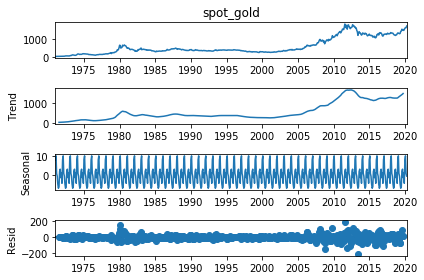

In [185]:
# Strong Seasonal component observed
decompose = seasonal_decompose(gold['spot_gold'], model='add')
decompose.plot();

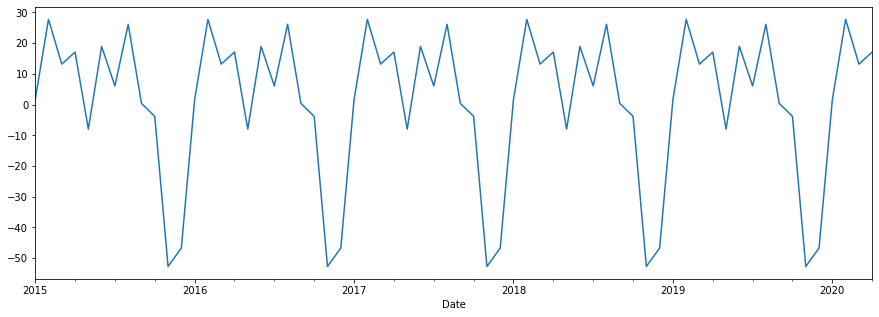

In [186]:
# Zoom-in the seasonal decompose
decompose1 = seasonal_decompose(gold['spot_gold']['2015':], model='add')
decompose1.seasonal.plot(figsize=(15,5))

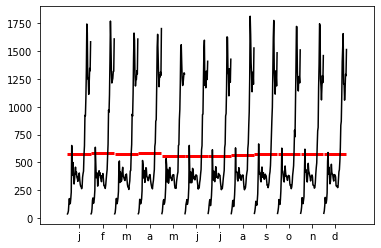

In [223]:
month_plot(combined_to_Apr20['spot_gold']);

<a id='base'></a>
### Baseline prediction with SARIMA (no exogenous variables)

#### SARIMA (Modelling Sequence)

<img src="../misc/sarima_describe.jpg" width="650" align="left">

In [187]:
# Like GridSearchCV, auto arima helps to find the best parameters for the ARIMA model
# Notice here, it is absolutely fine to use all data as we looking for the best weights for the model
# Seasonal set to true and since this is monthly, we set m =12
aa = auto_arima(combined_to_Apr20['spot_gold'], seasonal=True,m=12)

In [188]:
# auto_arima gives basic arima: p,d,q as (2, 1, 2) and
# Seaonal component values: (0, 0, 0, 12)
# Akaike information criterion (AIC). Lower AIC value indicates better fit
aa_aic = aa.aic()
aa_params = aa.get_params
print(f'auto_arima params: {aa_params}')
print(f'auto_arima aic: {aa_aic}')

auto_arima params: <bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>
auto_arima aic: 5973.099453537025


### Re-affirms the p,d,q values

auto_arima generates p,d,q values, we can use corss check with:<br>
- pandas diff() method to check 'd'<br>
- acf_plot to check 'q' (for MA values)<br>
- pacf_plot to check 'p' (AR values) <br>
NB: for both acf and pacf plots:<br>
Markers outside 'blue band' indicates that it is statistically significant

In [189]:
# First Order Differencing
# Non-stationary data can be made to look stationary through differencing. 
# It calculates the difference between consecutive observations.
# auto_arima gives 'd' as 1, so we perform k_diff=1 (pandas differencing)
# The data should be stationary after k_diff=1 differencing and it is
df1 = diff(gold['spot_gold'],k_diff=1)
adf_test(df1)

ADF test statistic       -5.482714
p-value                   0.000002
# lags used              10.000000
# observations          580.000000
critical value (1%)      -3.441675
critical value (5%)      -2.866536
critical value (10%)     -2.569431
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary


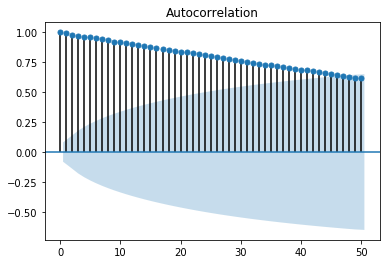

In [190]:
# Points above the blue band(95% confidence level), is a candidate value for MA
# From this plot: MA can be anywhere 1 to 45
plot_acf(combined_to_Apr20['spot_gold'],lags =50);

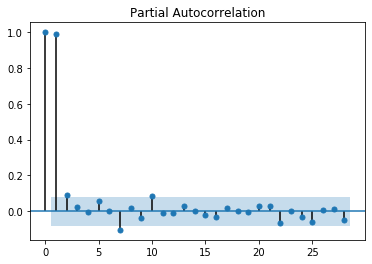

In [191]:
# AR value should be 1 to 2 (2 is just over the blue band)
plot_pacf(combined_to_Apr20['spot_gold'],);

In [192]:
len(combined_to_Apr20)   

592

In [193]:
# We cannot use random samples of data in time series
# So the popular sklearn train_test_split() wont work here
train = combined_to_Apr20[:584]
test = combined_to_Apr20[584:]

In [194]:
# Basically a SARIMA model here, without the exogenous variable stated
# Uses only train data to train the model
model = SARIMAX(train['spot_gold'],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
results = model.fit()

# Looking at the column 'P>|Z|'(for ar.L and ma.L), all the p-values are less than 0.05, so the AR and MA values are ok
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              spot_gold   No. Observations:                  584
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2937.852
Date:                Thu, 11 Jun 2020   AIC                           5885.705
Time:                        18:38:17   BIC                           5907.546
Sample:                    01-01-1971   HQIC                          5894.218
                         - 08-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3767      0.018    -78.121      0.000      -1.411      -1.342
ar.L2         -0.9532      0.021    -44.500      0.000      -0.995      -0.911
ma.L1          1.3514      0.027     50.885      0.000       1.299       1.403
ma.L2          0.8963      0.030     30.354      0.000       0.838       0.954
sigma2      1393.9005     39.946     34.894      0.000    1315.608    1472.193
===================================================================================
Ljung-Box (Q):                      105.33   Jarque-Bera (JB):              1237.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [195]:
start = len(train)
end =  len(train) + len(test) - 1

In [196]:
predictions = results.predict(start=start,end=end).rename('Baseline SARIMA Predictions')

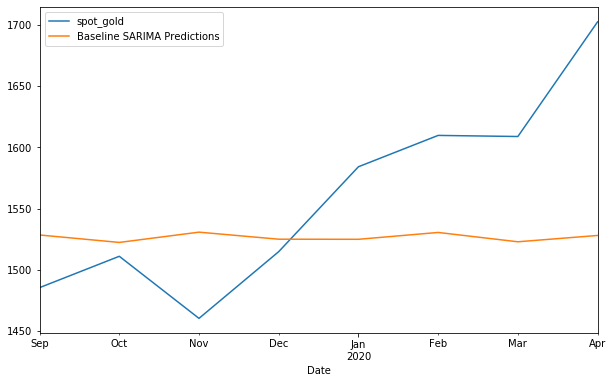

In [197]:
test['spot_gold'].plot(legend=True, figsize=(10,6))
predictions.plot(legend=True)

In [198]:
#predictions = results.predict().rename('SARIMA Predictions')
#gold['spot gold']['2010':].plot(legend=True, figsize=(16,5))
#predictions['2010':].plot(legend=True)

### Evaluating forecast accuracy
The choice of loss function:<br>
A forecast method that minimizes the MAE will lead to forecasts of the median, <br>
while minimizing the RMSE will lead to forecasts of the mean.

In [199]:
# Baseline rmse score of 82.8 for SARIMA model
error = rmse(test['spot_gold'],predictions)
error

82.80232669730505

In [200]:
# making sense of rmse score by comparing with predictions.mean()
predictions.mean()

1526.5503883650983

<a id='sx1'></a>
### SARIMAX models (with single exogenous variables)

Previously, I ran the Granger Causality Test with the following:<br>
CPI P value is 0.13323519021891975    - Moderate<br>
Rates P value is 0.004218511000755467 - Best performing<br>
USD P value is 0.3373749476541396     - Worst<br>

Without jumping into modelling 3 exogenous variables all at once <br>
I wanted to look at the performance when I ran 3 diifferent models, each time with just 1 exogenous variable.<br>

#### SARIMAX (Modelling Sequence)

<img src="../misc/sarimax_describe.jpg" width="650" align="left">

In [201]:
# Again, can use the full data while getting best params from auto_arima
aa_for_cpi = auto_arima(combined_to_Apr20['spot_gold'], exogenous=combined_to_Apr20[['us_cpi_inflation']],seasonal=True,m=12)
aa_for_rates = auto_arima(combined_to_Apr20['spot_gold'], exogenous=combined_to_Apr20[['fed_interest_rate']],seasonal=True,m=12)
aa_for_usd = auto_arima(combined_to_Apr20['spot_gold'], exogenous=combined_to_Apr20[['usd_index']],seasonal=True,m=12)

print(f'auto_arima params for cpi: {aa_for_cpi.get_params}')
print(f'auto_arima params for rates: {aa_for_rates.get_params}')
print(f'auto_arima params for usd: {aa_for_usd.get_params}')

auto_arima params for cpi: <bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))>
auto_arima params for rates: <bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>
auto_arima params for usd: <bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>


In [202]:
#train = combined1[:596]
#test = combined1[596:]

In [203]:
# Creating and fitting the models
cpi_model = SARIMAX(train['spot_gold'],exog=train[['us_cpi_inflation']],order=(2, 1, 2),seasonal_order=(1, 0, 1, 12),enforce_invertibility=False)
rates_model = SARIMAX(train['spot_gold'],exog=train[['fed_interest_rate']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
usd_model = SARIMAX(train['spot_gold'],exog=train[['usd_index']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)

cpi_result = cpi_model.fit()
rates_result = rates_model.fit()
usd_result = usd_model.fit()

In [204]:
# Generates predictions to be used for RMSE caculations
cpi_predictions = cpi_result.predict(start=start,end=end, exog=test[['us_cpi_inflation']]).rename('SARIMAX1 Predictions')
rates_predictions = rates_result.predict(start=start,end=end, exog=test[['fed_interest_rate']]).rename('SARIMAX2 Predictions')
usd_predictions = usd_result.predict(start=start,end=end, exog=test[['usd_index']]).rename('SARIMAX3 Predictions')

In [205]:
# Evaluates all 3 individual models base on the loss function and AIC values(lower better)
# RMSE errors outcome coincides with Granger Causality Test with 'rates' having best and 'USD having worst values
# AIC 

cpi_error = rmse(test['spot_gold'],cpi_predictions)
rates_error = rmse(test['spot_gold'],rates_predictions)
usd_error = rmse(test['spot_gold'],usd_predictions)

cpi_aic = aa_for_cpi.aic()
rates_aic = aa_for_rates.aic()
usd_aic = aa_for_usd.aic()

print(f'RMSE for CPI: {cpi_error}')
print(f'RMSE for Rates: {rates_error}')
print(f'RMSE for USD: {usd_error}')
print('\n')
print(f'AIC for CPI: {cpi_aic}')
print(f'AIC for Rates: {rates_aic}')
print(f'AIC for USD: {usd_aic}')

RMSE for CPI: 81.80382625413476
RMSE for Rates: 77.81746801189529
RMSE for USD: 83.3049951485003


AIC for CPI: 5972.709870551173
AIC for Rates: 5968.668418014264
AIC for USD: 5931.302381813731


<a id='sx2'></a>
### SARIMAX (with 2 exogenous variables)

Full SARIMAX model fitted by train data<br>

In [206]:
aa_final = auto_arima(combined_to_Apr20['spot_gold'], exogenous=combined_to_Apr20[['us_cpi_inflation','fed_interest_rate']],seasonal=True,m=12)
print(f'auto_arima params for cpi: {aa_final.get_params}')

auto_arima params for cpi: <bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>


In [207]:
sx_model = SARIMAX(train['spot_gold'],exog=train[['us_cpi_inflation','fed_interest_rate']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
sx_results = sx_model.fit()

In [208]:
start = len(train)
end =  len(train) + len(test) - 1

In [209]:
sx_predictions = sx_results.predict(start=start,end=end, exog=test[['us_cpi_inflation','fed_interest_rate']]).rename('SARIMAX Predictions')

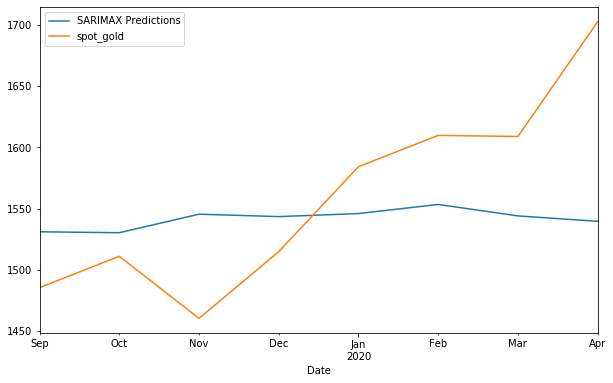

In [210]:
sx_predictions.plot(legend=True, figsize=(10,6))
test['spot_gold'].plot(legend=True)

In [211]:
error = rmse(test['spot_gold'],sx_predictions)
error

75.87364850143739

In [212]:
combined.shape

(600, 4)

<a id='full_sx'></a>
### Full model SARIMAX

Final full model fitted with full data<br>
(Model params based on previous full data auto_arima)

In [213]:
final_sx_model = SARIMAX(combined_to_Apr20['spot_gold'],exog=combined_to_Apr20[['us_cpi_inflation','fed_interest_rate']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
final_sx_results = final_sx_model.fit()

In [214]:
exog_fcast = combined[592:][['us_cpi_inflation','fed_interest_rate']]

In [215]:
final_sx_fcast = final_sx_results.predict(len(combined_to_Apr20),len(combined_to_Apr20)+7,exog=exog_fcast).rename('final_sx_fcast')

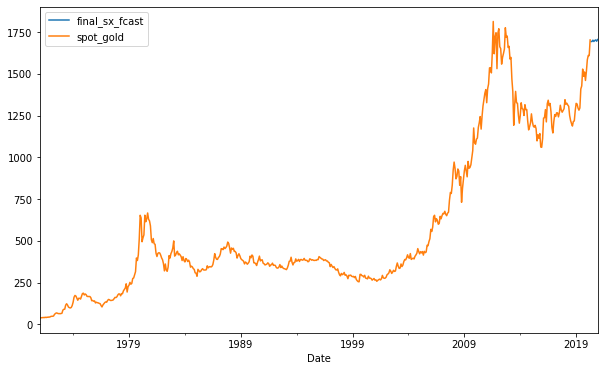

In [216]:
final_sx_fcast.plot(legend=True, figsize=(10,6))
combined_to_Apr20['spot_gold'].plot(legend=True)

In [217]:
fcast_may_to_dec20 = final_sx_results.predict(start='2019-09-01',end='2020-04-01',exog=exog_fcast).rename('final_sx_fcast')

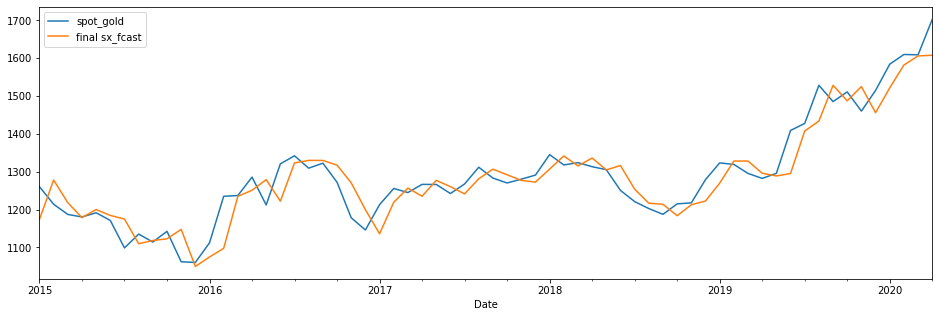

In [218]:
final_sx_fcast_all = final_sx_results.predict(exog=exog_fcast).rename('final sx_fcast')
combined_to_Apr20['spot_gold']['2015':].plot(legend=True, figsize=(16,5))
final_sx_fcast_all['2015':].plot(legend=True)

In [221]:
error_sep19_to_apr20 = rmse(test['spot_gold'],fcast_may_to_dec20)
error_1971_to_apr20 = rmse(combined_to_Apr20['spot_gold'],final_sx_fcast_all)
final_aic = aa_final.aic()


print(f'Full model RMSE for recent 8 months: {error_sep19_to_apr20}')
print(f'Full model RMSE for 50 years: {error_1971_to_apr20}')
print(f'Final AIC: {final_aic}')

Full model RMSE for recent 8 months: 54.52885623629973
Full model RMSE for 50 years: 37.87292054680011
Final AIC: 5968.924664679485


### Compile a table of the results:

RMSE and AIC scores
- Basic SARIMA
- SARIMAX1
- SARIMAX2
- SARIMAX3
- SARIMAX_full(2 Exog)

<a id='export'></a>
### Export data

In [220]:
# EXporting with indexes (since index is the dates)
gold.to_csv('../data/gold_clean.csv')
cpi.to_csv('../data/cpi_clean.csv')
rates.to_csv('../data/rates_clean.csv')
usd.to_csv('../data/usd_clean.csv')
combined.to_csv('../data/combined_clean.csv')
combined_to_Apr20.to_csv('../data/combined_to_Apr20_clean.csv')